In [1]:
from community import community_louvain
import gc
import logging
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from scipy.optimize import differential_evolution, basinhopping
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_probability as tfp
import warnings
logger = tf.get_logger()

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
logging.basicConfig(encoding='utf-8', level=logging.DEBUG,
                    force = True)

In [3]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [4]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [107]:
def clip(l,r,x):
    return max(l,min(r,x))

def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c),dtype= 'float64')
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_theta(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
#     logging.debug("Max degree = {}".format(max_degree))
    if max_degree == 0:
        return np.array([1 for i in range(n)])
#     return np.array([clip(0,1,1 - G.degree(i)/max_degree + random.random()/1000) for i in range(n)])  # Works bad for small graphs
    return np.array([random.random() for i in range(n)])

def build_network(G):
    logging.info("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    theta = build_theta(G)
#     logging.debug("Initial theta = {}".format(theta))
    return (W,b,w, theta, C)


In [139]:
def get_result_nodes(theta, alpha = 0.5):
    return set(np.argwhere(theta > alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, result_nodes):
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    node_not_connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False
            
def graph_has_no_edges(G, result_nodes):
    for v in result_nodes:
        for edge in G.neighbors(v):
            if edge in result_nodes:
                return False
    return True
            
def result_is_valid(G, theta):
    result_nodes = get_result_nodes(theta)
    return graph_has_no_edges(G, result_nodes) and not not_connected_nodes_exist_in_G(G, result_nodes)
    
def network(theta,e_n,W_t,b,w_t):
        h = tf.math.multiply(e_n,theta)
        h = tf.linalg.matvec(W_t,h)
        h = tf.add(h,b)
        h = tf.nn.relu(h)
        h = tf.tensordot(w_t,h, 1)
        return h
    
def network_evol(theta,e_n,W_t,b,w_t):
    return network(theta,e_n,W_t,b,w_t).numpy()

def loss(theta,e_n,W_t,b,w_t,h_d):
    h = network(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2   

def loss_evol(theta,e_n,W_t,b,w_t,h_d):
    h = network_evol(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2  

def evolutionary_train(n,theta,e_n,W_t,b,w_t,h_d):
    bounds = [(0,1) for i in range(n)]
    theta = differential_evolution(loss_evol, bounds, x0 = theta, args = (e_n,W_t,b,w_t,h_d))
    theta = theta.x
    return theta

def gradient_train(G, max_epochs, theta,e_n,W_t,b,w_t,h_d):
    optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    epoch = 0

    def local_loss():
        return loss(theta,e_n,W_t,b,w_t,h_d)
    previous_theta = theta.numpy()
    while not result_is_valid(G, theta) and epoch < max_epochs:
        logging.debug("Epoch = {}".format(epoch))
        optimizer.minimize(local_loss, var_list=[theta])
        logging.debug("theta = {}".format(theta))
        previous_error = local_loss()
    #         logging.debug("Loss = {}".format(previous_error))
        epoch+=1
        if (previous_theta == theta.numpy()).all():
            logging.debug("Solver stuck")
            break
        previous_theta = theta.numpy()
    if result_is_valid(G, theta):
        logging.debug("Optimal solution found. Cardinality = {}".format(len(get_result_nodes(theta))))
    return theta.numpy()

def annealing_train(G, max_epochs, theta,e_n,W_t,b,w_t,h_d):
    optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    epoch = 0

    def local_loss():
        return loss(theta,e_n,W_t,b,w_t,h_d)
    previous_theta = theta.numpy()
    while not result_is_valid(G, theta) and epoch < max_epochs:
        logging.debug("Epoch = {}".format(epoch))
        optimizer.minimize(local_loss, var_list=[theta])
        logging.debug("theta = {}".format(theta))
        previous_error = local_loss()
    #         logging.debug("Loss = {}".format(previous_error))
        epoch+=1
        if (previous_theta == theta.numpy()).all():
            logging.debug("Solver stuck")
            break
        previous_theta = theta.numpy()
    if result_is_valid(G, theta):
        logging.debug("Optimal solution found. Cardinality = {}".format(len(get_result_nodes(theta))))
    return theta.numpy()

def train_network(G, max_epochs = 100, method="evolutionary"):
    (W,b,w, theta, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float64')
    b = tf.constant(b, dtype = 'float64')
    w_t = tf.constant(w.T, dtype = 'float64')
    theta = tf.Variable(theta,
                        trainable=True,
                        constraint = lambda x: tf.clip_by_value(theta,0,1),
                        dtype = 'float64')
    e_n = tf.constant(np.ones((n)),dtype = 'float64')
    h_d = -n*n/2

    if method == "evolutionary":
        theta = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    elif method == "gradient":
        theta = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
    elif method == "annealing":
        theta = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
    return theta

In [126]:
def graphSets(graph): # Determinative algorithm to use correctness of the solution. Works too long for graphs >= 30 nodes.
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [127]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [128]:
def calculate_DNN_result(G, theta, threshold = 0.5, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(theta)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [129]:
def compareResults(G, max_epochs = 100, draw_graph = False):
#     calculate_recursive_broot_force_result(G)
    theta = train_network(G, max_epochs)
#     calculate_determenistic_result(G, draw_graph)
    calculate_DNN_result(G, theta, draw_graph=draw_graph)

In [130]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

INFO:root:Build network on graph G:Graph with 8 nodes and 12 edges.
DEBUG:root:Epoch = 0
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.79670177, 0.77296797, 0.47287406, 0.16102935, 0.39756507,
       0.79298596, 0.82791766, 0.55500025])>
DEBUG:root:Epoch = 1
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.69749231, 0.68084095, 0.38770021, 0.09402352, 0.30337484,
       0.70085894, 0.7287082 , 0.45580763])>
DEBUG:root:Epoch = 2
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.60001331, 0.59191401, 0.30702821, 0.04222783, 0.21188873,
       0.61292928, 0.6312292 , 0.35760475])>
DEBUG:root:Epoch = 3
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.50771808, 0.51258029, 0.24094662, 0.        , 0.13694887,
       0.54693701, 0.54613933, 0.27716292])>
DEBUG:root:Epoch = 4
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float

DEBUG:root:Epoch = 39
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08395369, 0.        , 0.        ])>
DEBUG:root:Epoch = 40
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08258903, 0.        , 0.        ])>
DEBUG:root:Epoch = 41
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08134732, 0.        , 0.        ])>
DEBUG:root:Epoch = 42
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08021763, 0.        , 0.        ])>
DEBUG:root:Epoch = 43
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.       

DEBUG:root:Epoch = 78
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.0693352,
       0.       , 0.       ])>
DEBUG:root:Epoch = 79
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.      , 0.      , 0.      , 0.      , 0.      , 0.069304,
       0.      , 0.      ])>
DEBUG:root:Epoch = 80
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06927573, 0.        , 0.        ])>
DEBUG:root:Epoch = 81
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06925013, 0.        , 0.        ])>
DEBUG:root:Epoch = 82
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.

DNN approach
set()
Length = 0


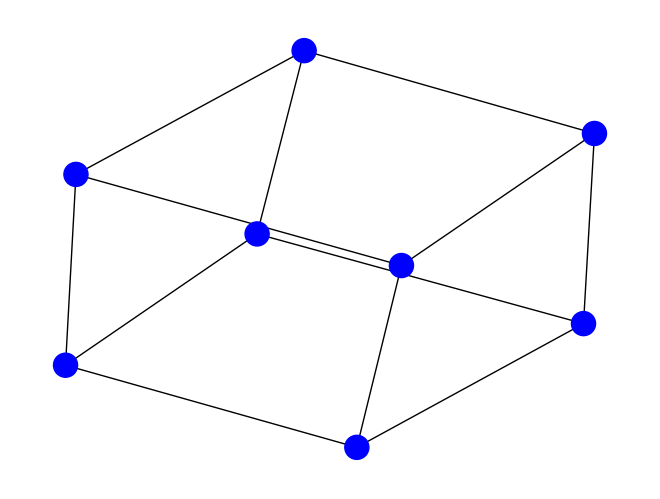

In [131]:
# compareResults(build_test_graph1(), 100, True)

In [ ]:
# compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

In [ ]:
# compareResults(nx.graph_atlas(1000),draw_graph=True)

INFO:root:Build network on graph G:Graph with 20 nodes and 18 edges.
DEBUG:root:Epoch = 0
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.47024365, 0.43990762, 0.68175781, 0.62100239, 0.15106888,
       0.48921794, 0.31123729, 0.64711079, 0.00962105, 0.31460541,
       0.34931072, 0.47221693, 0.28102597, 0.25455472, 0.6278401 ,
       0.51581056, 0.18878156, 0.55000485, 0.9173514 , 0.8750067 ])>
DEBUG:root:Epoch = 1
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.56995624, 0.41355097, 0.58165396, 0.5211485 , 0.24840723,
       0.58893052, 0.41094988, 0.54702993, 0.00962105, 0.414318  ,
       0.4490233 , 0.38221068, 0.37836431, 0.35189307, 0.54292253,
       0.4158595 , 0.13137439, 0.44994651, 1.        , 0.77529412])>
DEBUG:root:Epoch = 2
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.66996733, 0.40676456, 0.48149737, 0.45592659, 0.3470982 ,
       0.68844976, 0.510

DNN approach
{0, 3, 5, 7, 8, 9, 10, 12, 13, 14, 18, 19}
Length = 12


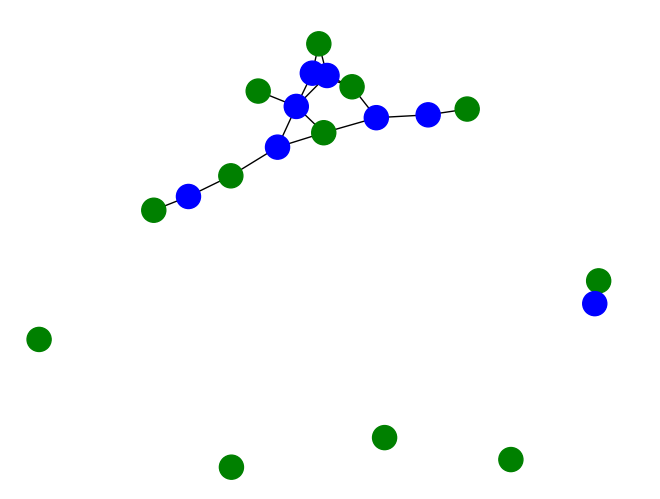

In [135]:
compareResults(nx.gnp_random_graph(20, 0.1), 200, True) #Expected result around 12-14

In [ ]:
# compareResults(nx.gnp_random_graph(50, 0.075), max_epochs = 1000)

In [ ]:
# compareResults(nx.gnp_random_graph(100, 0.1), max_epochs = 1000, draw_graph=False)

In [ ]:
wiki_vote_G = read_G_from_file('datasets/Wiki-Vote.txt') 

In [ ]:
print(wiki_vote_G)

In [12]:
def find_inter_cluster_edges(G, communities):
    edges = dict()
    for com in communities:
        for node_i in communities[com]:
            for neighbour_i in G.neighbors(node_i):
                if neighbour_i not in communities[com]:
                    if edges.get(node_i) is not None:
                        edges[node_i].append(neighbour_i)
                    else:
                        edges[node_i] = [neighbour_i]
                    if edges.get(neighbour_i) is not None:
                        edges[neighbour_i].append(node_i)
                    else:
                        edges[neighbour_i] = [node_i]
    return edges

def find_forbidden_edges(G, R, independent_sets):
    forbidden = []
    for node, edges in R.items():
        if node in independent_sets:
            for edge in edges:
                if edge in independent_sets:
                    forbidden.append((node, edge))
    return forbidden

def collect_list_by_dicts_key(partitions):
    communities = {}
    for key, val in partitions.items():
        if communities.get(val) == None:
            communities[val] = [key]
        else:
            communities[val].append(key)
    return communities

def build_G_from_nodes(G, nodes):
    communities = {}
    N = len(nodes)
    new_G = nx.Graph()
    index_map = dict()
    node_map = dict()
    index = 0
    for node in nodes:
        index_map[index] = node
        node_map[node] = index
        new_G.add_node(index)
        index+=1

    for i in nodes:
        for j in nodes:
            if G.has_edge(i,j):
                new_G.add_edge(node_map[i], node_map[j])
                new_G.add_edge(node_map[j], node_map[i])
    return (new_G, index_map, node_map)

In [144]:
def node_is_new_candidate(G, node, mis):
    neighbors = G.neighbors(node)
    neighbours_in_mis_count = 0
    for w in neighbors:
        if w in mis:
            neighbours_in_mis_count += 1
            if neighbours_in_mis_count == 2:
                break
            if neighbours_in_mis_count == 1:
                return (True, w)
    return (False, -1) 

def get_node_with_most_occurences(F, q, v):
    count_q = 0
    count_v = 0
    for x,y in F:
        if x == q:
            count_q+=1
        if y == v:
            count_v+=1
    if count_q > v:
        return q
    else:
        return v
            
def replace_node_if_possible(G,F,mis,node):
    if node not in mis:
        return True
    (can_be_replaced, new_node) = node_is_new_candidate(G,node,mis)
    if can_be_replaced:
        mis.remove(node)
        mis.add(new_node)
        return True
    return False 
        
def replace_forbiden_nodes(G,R,F,mis):
    logging.info("Replacing forbiden nodes")
    while len(F) > 0:
        logging.debug("Length of F = {}".format(len(F)))
        for q,v in F:
            replaced = replace_node_if_possible(G,F,mis,q)
            if replaced:
                break
            else:
                replaced = replace_node_if_possible(G,F,mis,v)
            if replaced:
                break
            else:
                node_to_be_removed = get_node_with_most_occurences(F,q,v)
                mis.remove(node_to_be_removed)
        F = find_forbidden_edges(G, R, mis)
    return mis

def build_G_from_left_nodes(G, mis):
    mis_with_neighbours = set()
    for node in mis:
        mis_with_neighbours.add(node)
        for neighbour in G.neighbors(node):
            mis_with_neighbours.add(neighbour)
    nodes_left_to_process = set(G.nodes()).difference(mis_with_neighbours)
    return build_G_from_nodes(G,nodes_left_to_process)

def calculate_mis_with_left_nodes(G, mis_list, max_epochs,method):
    (left_G, left_index_map, left_node_map)  = build_G_from_left_nodes(G, mis_list)
    logging.info("Left nodes size = {}".format(len(left_G.nodes())))
    if len(left_G.nodes()) > 1000:
        mis = calculate_large_G(left_G, max_epochs)
    else:
        mis = get_result_nodes(train_network(left_G, max_epochs,method))
    mis_correct = [left_index_map[node] for node in mis]
    mis_final = mis_list.union(mis)
    return mis_final

In [145]:
def calculate_large_G(G, max_epochs = 1000, method='gradient'):
    gc.collect()
    partitions = community_louvain.best_partition(G, resolution= 0.8)
    communities = collect_list_by_dicts_key(partitions)
    logging.info("Total communities {}".format(len(communities)))
    R = find_inter_cluster_edges(G, communities)
    mis_list = set()
    community_index = 1
    for com in communities:
        logging.info("Community {} processing...".format(community_index))
        (small_G,index_map, node_map) = build_G_from_nodes(G, communities[com])
        theta_for_small_G = train_network(small_G, max_epochs,method)
        mis = get_result_nodes(theta_for_small_G)
        mis_correct = [index_map[node] for node in mis]
        mis_list = mis_list.union(mis_correct)
        community_index += 1
    F = find_forbidden_edges(G, R, mis_list)
    replace_forbiden_nodes(G,R,F,mis_list)
    return calculate_mis_with_left_nodes(G, mis_list, max_epochs,method)

In [ ]:
# wiki_vote_G_MIS = calculate_large_G(wiki_vote_G, 1000)

In [153]:
def test_average_result_on_graph(G, graph_name, iterations = 10):
    sum = 0
    for i in range(iterations):
        mis = calculate_large_G(G, 50)
        sum+=len(mis)
    print("dNN result on {} = {}".format(graph_name,sum/iterations))

def test_network_on_graphs(graphs, method='gradient'):
    sum = 0
    n = len(graphs)
    for i in range(n):
        mis = calculate_large_G(graphs[i], 50,method)
        sum+=len(mis)
    print("Average dNN result = {}".format(sum/n))
    
def build_n_graphs(n, graph_func):
    return [graph_func() for i in range(n)]

In [154]:
networks = build_n_graphs(3, lambda: nx.erdos_renyi_graph(100,0.1), )

In [156]:
test_network_on_graphs(networks, 'evolutionary')

INFO:root:Total communities 9
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 32 edges.
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 17 edges.
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 29 edges.
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 8 edges.
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 14 edges.
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 23 edges.
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 17 edges.
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 24 edges.
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 23 edges.
INFO:root:Replacing forbiden

Average dNN result = 25.0


In [157]:
test_network_on_graphs(networks, 'gradient')

INFO:root:Total communities 8
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 32 edges.
DEBUG:root:Epoch = 0
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=
array([0.4809417 , 0.        , 0.77709001, 0.06025854, 0.30652936,
       0.89979071, 0.43412912, 0.83131058, 0.82650972, 0.09025966,
       0.45990288, 0.20808042, 0.61207829, 0.26682068, 0.18130296,
       0.89533993])>
DEBUG:root:Epoch = 1
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=
array([0.40039774, 0.        , 0.680116  , 0.        , 0.20779556,
       0.82106049, 0.34659618, 0.73529654, 0.73350299, 0.02325384,
       0.37236994, 0.16392283, 0.51924013, 0.36542169, 0.08596248,
       0.79629785])>
DEBUG:root:Epoch = 2
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=
array([0.32764982, 0.        , 0.58784543, 0.        , 0.11767381,
       0.74814216, 0.26354737, 0.65040091, 0.64718571,

DEBUG:root:Epoch = 25
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.03118294])>
DEBUG:root:Epoch = 26
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.02828988])>
DEBUG:root:Epoch = 27
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.02647182])>
DEBUG:root:Epoch = 28
DEBUG:roo

DEBUG:root:Epoch = 1
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.64892853, 0.        , 0.09449937, 0.4111878 , 0.80392463,
       0.        , 0.78915541, 0.34498063, 0.53839576, 0.24076282,
       0.49561926, 0.3326588 , 0.72676681, 0.        , 0.00411598,
       0.40302358, 0.5983156 , 0.34728911, 0.        , 0.30605823])>
DEBUG:root:Epoch = 2
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.55102224, 0.        , 0.02500555, 0.31101673, 0.71592936,
       0.        , 0.69677298, 0.44237722, 0.4567658 , 0.19408799,
       0.40189649, 0.43005538, 0.6432942 , 0.        , 0.00411598,
       0.31392706, 0.5099146 , 0.25185905, 0.        , 0.40345482])>
DEBUG:root:Epoch = 3
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.45814046, 0.        , 0.        , 0.21061051, 0.63487878,
       0.        , 0.6087592 , 0.53810838, 0.38102154, 0.1558548 ,
       0.31747147, 0.52578

DEBUG:root:Epoch = 24
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.04395321,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.45768413, 0.05141425, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.37600642])>
DEBUG:root:Epoch = 25
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.03869781,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.4820083 , 0.04627997, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.39643219])>
DEBUG:root:Epoch = 26
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.03447243,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.50

DEBUG:root:Epoch = 47
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.08282753,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.57697585, 0.06562785, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.35332733])>
DEBUG:root:Epoch = 48
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.08879104,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.55325837, 0.06973856, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.32118878])>
DEBUG:root:Epoch = 49
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(20,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.09493789,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.53

DEBUG:root:Epoch = 32
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.        , 0.20169502, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 33
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.        , 0.21265677, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 34
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.        , 0.22416981, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 35
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.        , 0.23620077, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 36
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
arra

DEBUG:root:Epoch = 16
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.09567249, 0.20626795, 0.        , 0.09925556,
       0.09820353, 0.        , 0.05262671, 0.        , 0.00678319,
       0.        , 0.        ])>
DEBUG:root:Epoch = 17
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.08320395, 0.19795039, 0.        , 0.09925556,
       0.09820353, 0.        , 0.04619918, 0.        , 0.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 18
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.07187199, 0.19039103, 0.        , 0.09925556,
       0.09820353, 0.        , 0.04035756, 0.        , 0.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 19
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.06156661, 0.18351648, 0.        , 0.09925556,
       0.09820353, 0.       

DEBUG:root:Epoch = 47
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.11855156, 0.        , 0.09925556,
       0.09820353, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 48
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.11810051, 0.        , 0.09925556,
       0.09820353, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 49
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.11769057, 0.        , 0.09925556,
       0.09820353, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])>
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 34 edges.
DEBUG:root:Epoch = 0
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(15,) dtype=float64

DEBUG:root:Epoch = 24
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02782892,
       0.        , 0.        , 0.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 25
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02606701,
       0.        , 0.        , 0.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 26
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02446176,
       0.        , 0.        , 0.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 27
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(15,) dtype=flo

DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.10456194, 0.02804451, 0.65342856, 0.15628403, 0.57461456,
       0.        , 0.59606599, 0.23734571, 0.73611984, 0.63595459])>
DEBUG:root:Epoch = 2
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.03267379, 0.02804451, 0.55347386, 0.1129409 , 0.49439326,
       0.        , 0.49611129, 0.16962274, 0.65468016, 0.53986443])>
DEBUG:root:Epoch = 3
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.        , 0.02804451, 0.45340101, 0.07743685, 0.41639699,
       0.        , 0.39584664, 0.1141482 , 0.58007544, 0.4460729 ])>
DEBUG:root:Epoch = 4
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.        , 0.02804451, 0.37351532, 0.04742783, 0.35047235,
       0.        , 0.31110014, 0.06725956, 0.52103678, 0.36743635])>
DEBUG:root:Epoch = 5
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,)

DEBUG:root:Epoch = 36
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.        , 0.02804451, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05640896, 0.        ])>
DEBUG:root:Epoch = 37
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.        , 0.02804451, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05434544, 0.        ])>
DEBUG:root:Epoch = 38
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.        , 0.02804451, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.052467  , 0.        ])>
DEBUG:root:Epoch = 39
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.        , 0.02804451, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0507573 , 0.        ])>
DEBUG:root:Epoch = 40
DEBUG:root:theta = <tf.Variabl

DEBUG:root:Epoch = 19
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.        , 0.        , 1.        , 0.        , 0.01650364,
       0.        , 0.        , 0.22222823, 0.        , 0.        ,
       0.        ])>
DEBUG:root:Epoch = 20
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.        , 0.        , 1.        , 0.        , 0.00913964,
       0.        , 0.        , 0.2398148 , 0.        , 0.        ,
       0.        ])>
DEBUG:root:Epoch = 21
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.        , 0.        , 1.        , 0.        , 0.00321752,
       0.        , 0.        , 0.25924541, 0.        , 0.        ,
       0.        ])>
DEBUG:root:Epoch = 22
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.28038827, 0.        , 0.       

DEBUG:root:Epoch = 3
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([0.62072259, 0.02734531, 0.05741077, 0.53792014, 0.52378331,
       0.30008631, 0.10947616, 0.32976962, 0.        , 0.10203158,
       0.54504955, 0.47408424, 0.03643501, 0.0076834 , 0.5819614 ,
       0.49583659, 0.54435476, 0.46504545, 0.06225   , 0.54890442,
       0.4277133 , 0.68633917, 0.02522386, 0.04754248, 0.40306683,
       0.03814915, 0.18781741, 0.33774229, 0.40011698, 0.48116876,
       0.02703336, 0.61467991, 0.0332157 , 0.51081615, 0.55352761,
       0.        , 0.07424275, 0.62942182, 0.3803473 , 0.14545483,
       0.3994045 ])>
DEBUG:root:Epoch = 4
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([0.65036495, 0.02734531, 0.05741077, 0.56189572, 0.44473784,
       0.25089328, 0.04020922, 0.2744765 , 0.        , 0.0487608 ,
       0.57060061, 0.39921309, 0.00183722, 0.        , 0.68174234,
       0.42025323, 0.56990582, 0.40091786,

DEBUG:root:Epoch = 16
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([9.31817046e-01, 4.45582053e-01, 0.00000000e+00, 9.70987598e-01,
       3.33814264e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.52227841e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 3.70934673e-03,
       1.00000000e+00, 6.54412810e-02, 0.00000000e+00, 3.68569060e-01,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 5.68753048e-01,
       1.10213997e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.95535321e-01,
       0.00000000e+00, 1.34674725e-01, 5.38111973e-02, 0.00000000e+00,
       0.00000000e+00, 7.51745891e-01, 3.30552492e-02, 0.00000000e+00,
       0.00000000e+00])>
DEBUG:root:Epoch = 17
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([0.95596532, 0.540743  , 0.        , 1.        , 0.      

DEBUG:root:Epoch = 29
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([1.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.09206813, 0.        , 0.62465083,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.33436922, 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        ])>
DEBUG:root:Epoch = 30
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([1.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.1045469

DEBUG:root:Epoch = 42
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([1.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.32528661, 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.84760579, 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        ])>
DEBUG:root:Epoch = 43
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(41,) dtype=float64, numpy=
array([1.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.3491753

DEBUG:root:Epoch = 10
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.12017643, 0.06985307, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.74841493, 0.        , 0.89630731,
       0.29249656, 0.        ])>
DEBUG:root:Epoch = 11
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.07586205, 0.03660202, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.76407734, 0.        , 0.90484026,
       0.27108879, 0.        ])>
DEBUG:root:Epoch = 12
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.03591254, 0.00662613, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.78281864, 0.        , 0.92011588,
       0.25310333, 0.        ])>
DEBUG:root:Epoch = 13
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.       

DEBUG:root:Epoch = 41
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.40189447, 0.        ])>
DEBUG:root:Epoch = 42
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.41769814, 0.        ])>
DEBUG:root:Epoch = 43
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.43384002, 0.        ])>
DEBUG:root:Epoch = 44
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.       

DEBUG:root:Epoch = 17
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(17,) dtype=float64, numpy=
array([0.32402699, 0.        , 0.53562931, 0.        , 0.41152328,
       0.        , 0.20870596, 0.        , 0.        , 0.        ,
       0.30531267, 0.        , 0.        , 0.        , 0.11763145,
       0.36666074, 1.        ])>
DEBUG:root:Epoch = 18
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(17,) dtype=float64, numpy=
array([0.32838927, 0.        , 0.55071564, 0.        , 0.43023448,
       0.        , 0.20697386, 0.        , 0.        , 0.        ,
       0.30025436, 0.        , 0.        , 0.        , 0.10648107,
       0.38276355, 1.        ])>
DEBUG:root:Epoch = 19
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(17,) dtype=float64, numpy=
array([0.33398751, 0.        , 0.56774339, 0.        , 0.44998795,
       0.        , 0.20675548, 0.        , 0.        , 0.        ,
       0.29628955, 0.        , 0.        , 0.        , 0.09657951,
       0.40057625, 1.       

DEBUG:root:Epoch = 42
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(17,) dtype=float64, numpy=
array([0.58501715, 0.        , 0.40476331, 0.        , 0.487086  ,
       0.        , 0.41323589, 0.        , 0.        , 0.        ,
       0.37208862, 0.        , 0.        , 0.        , 0.04931974,
       0.38180195, 1.        ])>
DEBUG:root:Epoch = 43
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(17,) dtype=float64, numpy=
array([0.58738093, 0.        , 0.40310278, 0.        , 0.46818241,
       0.        , 0.40328152, 0.        , 0.        , 0.        ,
       0.37937853, 0.        , 0.        , 0.        , 0.05117576,
       0.34890389, 1.        ])>
DEBUG:root:Epoch = 44
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(17,) dtype=float64, numpy=
array([0.59486257, 0.        , 0.40324673, 0.        , 0.45520046,
       0.        , 0.39587897, 0.        , 0.        , 0.        ,
       0.38685325, 0.        , 0.        , 0.        , 0.05318189,
       0.32113968, 1.       

DEBUG:root:Epoch = 19
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(14,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.01376934, 0.        ,
       0.        , 0.2283788 , 0.        , 0.        , 0.        ,
       0.01893102, 1.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 20
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(14,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.00319484, 0.        ,
       0.        , 0.22749354, 0.        , 0.        , 0.        ,
       0.00891814, 1.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 21
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(14,) dtype=float64, numpy=
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.27468107e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.88329002e-04, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00])>
DEBUG:root:Epoch = 22
DEBUG:root:theta = <tf.Variable 'Variab

DEBUG:root:Epoch = 47
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(14,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.39318207, 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 48
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(14,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.40315178, 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        ])>
DEBUG:root:Epoch = 49
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(14,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.41327987, 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        ])>
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 18 edges.
DEBUG:root:Epoch = 

DEBUG:root:Epoch = 16
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.05574227, 0.12994887, 0.01898867,
       0.        , 0.09763837, 0.        ])>
DEBUG:root:Epoch = 17
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.05129634, 0.11555966, 0.00592674,
       0.        , 0.0838748 , 0.        ])>
DEBUG:root:Epoch = 18
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.04725569, 0.10248212, 0.        ,
       0.        , 0.07136586, 0.        ])>
DEBUG:root:Epoch = 19
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.04358108, 0.09058929, 0.        ,
       0.        , 0.05999012, 0.        ])>
DEBUG:root:Epoch = 20
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
array([0.        , 0.        , 0.04023769, 0.0797684

DEBUG:root:Epoch = 1
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.14903946, 0.06144999, 0.5466104 , 0.06332039, 0.47730954,
       0.10125755, 0.46667649, 0.21900282, 0.16650308, 0.46788199,
       0.20812725, 0.57103725])>
DEBUG:root:Epoch = 2
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.09724376, 0.06144999, 0.47076277, 0.06332039, 0.41285486,
       0.10125755, 0.37973533, 0.16720712, 0.16650308, 0.56584986,
       0.15633155, 0.47114756])>
DEBUG:root:Epoch = 3
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.05481588, 0.06144999, 0.41007148, 0.06332039, 0.36005751,
       0.10125755, 0.30851842, 0.12477924, 0.16650308, 0.66241168,
       0.11390367, 0.39086694])>
DEBUG:root:Epoch = 4
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.01895464, 0.06144999, 0.36011866, 0.06332039, 0.31753319,
       0.10125755, 0.2483239 , 0

DEBUG:root:Epoch = 32
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.07632547, 0.21495572, 0.        , 0.36698405,
       0.30042813, 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 33
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.08686517, 0.22608006, 0.        , 0.38588876,
       0.31402202, 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 34
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.09960238, 0.23766013, 0.        , 0.40532565,
       0.32969736, 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 35
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.11436724, 0.24966945, 0.        , 0.42526784,
       0.34729533, 0.       

DEBUG:root:Epoch = 6
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(34,) dtype=float64, numpy=
array([0.        , 0.12267939, 0.        , 0.34699905, 1.        ,
       0.3233417 , 0.        , 0.11043245, 0.17800131, 0.        ,
       0.94180176, 0.        , 0.        , 0.94423187, 0.02391618,
       0.        , 0.40764458, 0.45328085, 0.15541816, 0.02604813,
       0.7916722 , 0.27695513, 0.24414876, 0.18837798, 0.64885933,
       0.30613239, 0.09418327, 0.47735927, 0.25736098, 0.78667066,
       0.57142882, 0.22640788, 0.36011416, 0.24515839])>
DEBUG:root:Epoch = 7
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(34,) dtype=float64, numpy=
array([0.00000000e+00, 9.98129602e-02, 0.00000000e+00, 3.14285360e-01,
       1.00000000e+00, 3.04787604e-01, 0.00000000e+00, 6.21216676e-02,
       1.18420408e-01, 0.00000000e+00, 9.91238805e-01, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.67068876e-01, 4.18350060e-01, 1.26978675e-01, 9.

DEBUG:root:Epoch = 21
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(34,) dtype=float64, numpy=
array([0.        , 0.1298312 , 0.        , 0.30055946, 1.        ,
       0.22982972, 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.18433999, 0.5256474 , 0.01849464, 0.        ,
       1.        , 0.02087798, 0.2393411 , 0.        , 0.82929969,
       0.12171561, 0.        , 0.42903568, 0.        , 1.        ,
       0.75698673, 0.33037885, 0.02822886, 0.06446362])>
DEBUG:root:Epoch = 22
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(34,) dtype=float64, numpy=
array([0.        , 0.14848559, 0.        , 0.32091507, 1.        ,
       0.23986008, 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.18701083, 0.53166778, 0.02335378, 0.        ,
       1.        , 0.0234303 , 0.25327989, 0.        , 0.85155241,
    

DEBUG:root:Epoch = 36
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(34,) dtype=float64, numpy=
array([0.        , 0.61915934, 0.        , 0.85164031, 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.3468724 , 0.61586393, 0.18767164, 0.        ,
       1.        , 0.        , 0.33210723, 0.        , 1.        ,
       0.        , 0.        , 0.38049243, 0.        , 1.        ,
       1.        , 0.6064662 , 0.02546011, 0.37178391])>
DEBUG:root:Epoch = 37
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(34,) dtype=float64, numpy=
array([0.        , 0.67091091, 0.        , 0.91397887, 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.36540194, 0.62264705, 0.20628258, 0.        ,
       1.        , 0.        , 0.31333719, 0.        , 1.        ,
    

DEBUG:root:Epoch = 1
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.56992702, 0.31949535, 0.66349199, 0.60447621, 0.60819623,
       0.77267743, 0.50853525, 0.56102255, 0.28732525, 0.79947231,
       0.1374828 ])>
DEBUG:root:Epoch = 2
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.48071229, 0.2264411 , 0.73436546, 0.50943971, 0.50979721,
       0.67520447, 0.41082368, 0.46262352, 0.38456244, 0.70205579,
       0.09192113])>
DEBUG:root:Epoch = 3
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.39962536, 0.15021673, 0.7819696 , 0.42421763, 0.41221214,
       0.57996431, 0.32111704, 0.37141331, 0.37684246, 0.60935376,
       0.05459978])>
DEBUG:root:Epoch = 4
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.33270595, 0.08578976, 0.81409734, 0.34919557, 0.33186889,
       0.49622429, 0.24572547, 0.29545588, 0.33560862, 0.52554514,
 

DEBUG:root:Epoch = 16
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.12776386, 0.03826044, 0.        , 0.        ,
       0.        , 0.02291105, 0.        , 0.        ])>
DEBUG:root:Epoch = 17
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.11201619, 0.02150872, 0.        , 0.        ,
       0.        , 0.02291105, 0.        , 0.        ])>
DEBUG:root:Epoch = 18
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.09770402, 0.00628403, 0.        , 0.        ,
       0.        , 0.02291105, 0.        , 0.        ])>
DEBUG:root:Epoch = 19
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.        , 0.0846884 , 0.        , 0.        , 0.        ,
       0.        , 0.02291105, 0.        , 0.        ])>
DEBUG:root:Epoch = 20
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
arra

DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.14816042, 0.        , 0.        ,
       0.2909043 , 0.        , 0.        , 0.09582074, 0.12982525,
       0.        , 0.17045944, 0.        ])>
DEBUG:root:Epoch = 17
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.13264719, 0.        , 0.        ,
       0.27956037, 0.        , 0.        , 0.08132465, 0.11577392,
       0.        , 0.15789026, 0.        ])>
DEBUG:root:Epoch = 18
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.11854809, 0.        , 0.        ,
       0.26925051, 0.        , 0.        , 0.06814996, 0.10300346,
       0.        , 0.14646684, 0.        ])>
DEBUG:root:Epoch = 19
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.10572624, 0.        , 0.        ,
       0.25987

DEBUG:root:Epoch = 46
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.17194881, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03865566, 0.        ])>
DEBUG:root:Epoch = 47
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.17127204, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03790579, 0.        ])>
DEBUG:root:Epoch = 48
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.17065687, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03722418, 0.        ])>
DEBUG:root:Epoch = 49
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(13,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.  

DEBUG:root:Epoch = 21
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(18,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.05102691, 0.        ,
       0.        , 0.        , 0.06196901, 0.35887352, 0.        ,
       0.27890633, 0.        , 0.        ])>
DEBUG:root:Epoch = 22
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(18,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.04391663, 0.        ,
       0.        , 0.        , 0.06460975, 0.37869175, 0.        ,
       0.27675184, 0.        , 0.        ])>
DEBUG:root:Epoch = 23
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(18,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.0376534 , 0.        ,
       0.        , 0.        , 0.068061  , 0.39966808, 0.        ,
    

DEBUG:root:Epoch = 45
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(18,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.01654679, 0.        ,
       0.        , 0.        , 0.01312856, 0.81671462, 0.        ,
       0.41229083, 0.        , 0.        ])>
DEBUG:root:Epoch = 46
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(18,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.01833357, 0.        ,
       0.        , 0.        , 0.00664714, 0.84134151, 0.        ,
       0.4261684 , 0.        , 0.        ])>
DEBUG:root:Epoch = 47
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(18,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.02023558, 0.        ,
       0.        , 0.        , 0.0019879 , 0.87053854, 0.        ,
    

DEBUG:root:Epoch = 24
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.       , 0.       , 0.       , 1.       , 0.       , 0.       ,
       0.       , 0.1657253, 0.       , 0.       , 0.       , 0.       ])>
DEBUG:root:Epoch = 25
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.16660031, 0.        , 0.        ,
       0.        , 0.        ])>
DEBUG:root:Epoch = 26
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.       , 0.       , 0.       , 1.       , 0.       , 0.       ,
       0.       , 0.1682649, 0.       , 0.       , 0.       , 0.       ])>
DEBUG:root:Epoch = 27
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.17065941, 0.        , 0.        ,

DEBUG:root:Epoch = 6
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.16821231, 0.        , 0.        , 0.79686652, 0.44537785,
       0.07123277, 0.00685537, 0.98975054, 0.54576468])>
DEBUG:root:Epoch = 7
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.12382888, 0.        , 0.        , 0.82824652, 0.45819694,
       0.02165734, 0.        , 1.        , 0.54146815])>
DEBUG:root:Epoch = 8
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.0879827 , 0.        , 0.        , 0.87057811, 0.47429413,
       0.        , 0.        , 1.        , 0.54257386])>
DEBUG:root:Epoch = 9
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0.05945268, 0.        , 0.        , 0.92146282, 0.49546401,
       0.        , 0.        , 1.        , 0.54990998])>
DEBUG:root:Epoch = 10
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([0

DEBUG:root:Solver stuck
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 37
INFO:root:Build network on graph G:Graph with 37 nodes and 71 edges.
DEBUG:root:Epoch = 0
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
array([0.6062173 , 0.49493462, 0.36884362, 0.36084599, 0.70150511,
       0.40839648, 0.28766087, 0.32354842, 0.25179277, 0.28007816,
       0.30056056, 0.39551667, 0.2778628 , 0.65772729, 0.36319026,
       0.54368119, 0.09273813, 0.78090677, 0.59970162, 0.81587222,
       0.40367695, 0.52990361, 0.38357201, 0.21574719, 0.27615207,
       0.31883886, 0.39713146, 0.35192094, 0.62781942, 0.79804357,
       0.51642957, 0.54957187, 0.34345741, 0.2433916 , 0.25779655,
       0.73262403, 0.56993088])>
DEBUG:root:Epoch = 1
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
a

DEBUG:root:Epoch = 14
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
array([0.04870448, 0.08592391, 0.        , 0.        , 1.        ,
       0.44212557, 0.11648084, 0.5868276 , 0.        , 0.        ,
       0.        , 0.        , 0.32943935, 0.        , 0.28374496,
       0.32790551, 0.        , 0.23957558, 1.        , 0.25470457,
       0.        , 0.32480256, 0.        , 0.        , 0.0740137 ,
       0.        , 0.        , 0.45079807, 0.13741113, 0.19837011,
       0.03898389, 0.18196326, 0.        , 0.35108802, 0.38945647,
       1.        , 0.44981348])>
DEBUG:root:Epoch = 15
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
array([0.02282696, 0.08454683, 0.        , 0.        , 1.        ,
       0.45070724, 0.11008236, 0.60197932, 0.        , 0.        ,
       0.        , 0.        , 0.3202867 , 0.        , 0.30253819,
       0.32950364, 0.        , 0.2288255 , 1.        , 0.24614754,
       0.        , 0.3374483

DEBUG:root:Epoch = 28
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
array([0.        , 0.20801719, 0.        , 0.        , 1.        ,
       0.47873112, 0.19417315, 0.65287824, 0.        , 0.        ,
       0.        , 0.        , 0.22214583, 0.        , 0.88593735,
       0.22594824, 0.        , 0.19733669, 1.        , 0.25456147,
       0.        , 0.2720307 , 0.        , 0.        , 0.42216952,
       0.        , 0.        , 0.54418439, 0.13926699, 0.18636125,
       0.02177241, 0.33625369, 0.        , 0.39439117, 0.4425157 ,
       1.        , 0.68867937])>
DEBUG:root:Epoch = 29
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
array([0.        , 0.2256856 , 0.        , 0.        , 1.        ,
       0.49084676, 0.20999929, 0.68001423, 0.        , 0.        ,
       0.        , 0.        , 0.23179548, 0.        , 0.97698866,
       0.2253246 , 0.        , 0.20056874, 1.        , 0.26197076,
       0.        , 0.2688959

DEBUG:root:Epoch = 42
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
array([0.        , 0.69701536, 0.        , 0.        , 1.        ,
       0.5888034 , 0.13981974, 0.82417568, 0.        , 0.        ,
       0.        , 0.        , 0.12623927, 0.        , 1.        ,
       0.14899219, 0.        , 0.31018733, 1.        , 0.48826839,
       0.        , 0.0600134 , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.66922711, 0.31335928, 0.38909571,
       0.        , 0.9879311 , 0.        , 0.39325239, 0.32097047,
       1.        , 0.84920826])>
DEBUG:root:Epoch = 43
DEBUG:root:theta = <tf.Variable 'Variable:0' shape=(37,) dtype=float64, numpy=
array([0.        , 0.7337809 , 0.        , 0.        , 1.        ,
       0.58627581, 0.13242992, 0.82668423, 0.        , 0.        ,
       0.        , 0.        , 0.14004465, 0.        , 1.        ,
       0.1216764 , 0.        , 0.32559205, 1.        , 0.51854235,
       0.        , 0.0708963

Average dNN result = 22.0


In [ ]:
test_average_result_on_graph(nx.erdos_renyi_graph(100,0.2),"ER 100, 0.2")

In [ ]:
test_average_result_on_graph(nx.erdos_renyi_graph(200,0.1),"ER 200, 0.1")

In [ ]:
test_average_result_on_graph(nx.erdos_renyi_graph(200,0.2),"ER 200, 0.2")

In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([250],[[0.1]]),"SBM 250, 0.1")

In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([250],[[0.2]]),"SBM 250, 0.2")

In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([350],[[0.1]]),"SBM 350, 0.1")

In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([350],[[0.2]]),"SBM 350, 0.2")

In [ ]:
test_average_result_on_graph(nx.barabasi_albert_graph(100,50),"BA 100")

In [ ]:
test_average_result_on_graph(nx.barabasi_albert_graph(200,90),"BA 200")

In [ ]:
test_average_result_on_graph(nx.powerlaw_cluster_graph(100,30,0.5),"HK 100")

In [ ]:
test_average_result_on_graph(nx.powerlaw_cluster_graph(200,60,0.5),"HK 200", 1)